#Fake News Detection


In [4]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.svm import SVC
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import gradio as gr

In [6]:
#Pre Processing the data
Truedata='/content/drive/MyDrive/Dataset/True.csv'
FakeData='/content/drive/MyDrive/Dataset/Fake.csv'
df1= pd.read_csv(FakeData)
df2= pd.read_csv(Truedata)
#Make all the data in lowercase
df1=df1.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
df2=df2.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
#Tokenize the data
nltk.download('punkt_tab')
nltk.download('wordnet')
df1['text']=df1['text'].apply(nltk.word_tokenize)
df2['text']=df2['text'].apply(nltk.word_tokenize)
df1['title']=df1['title'].apply(nltk.word_tokenize)
df2['title']=df2['title'].apply(nltk.word_tokenize)
df1['subject']=df1['subject'].apply(nltk.word_tokenize)
df2['subject']=df2['subject'].apply(nltk.word_tokenize)
#Lemmatizing words
lemmatizer = WordNetLemmatizer()
df1['text'] = df1['text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df2['text'] = df2['text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df1['title'] = df1['title'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df2['title'] = df2['title'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df1['subject'] = df1['subject'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df2['subject'] = df2['subject'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df1=train_test_split(df1, test_size=0.2, random_state=42)
df2=train_test_split(df2, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#Transforming data to numerical vectors using a pretrained word embedding called Word2vec
train_df1, test_df1 = df1
train_df2, test_df2 = df2
all_text = train_df1['text'].tolist() + test_df1['text'].tolist() + train_df2['text'].tolist() + test_df2['text'].tolist()
word_vectors = Word2Vec(sentences=all_text, window=5, min_count=5, workers=4)
# Save the model
word_vectors.wv.save_word2vec_format("word2vec_model.txt", binary=False)
# Access word vectors
vector = word_vectors.wv['example']

In [8]:
# Function to convert a list of tokens to a single vector
def document_vector(tokens, model):
  """
  Calculate the average word vector for a list of tokens
  """
  vectors = [model.wv[token] for token in tokens if token in model.wv]
  if vectors:
    return np.mean(vectors, axis=0)  # Average the word vectors
  else:
    return np.zeros(model.vector_size)  # Handle empty documents


In [13]:
# Create feature vectors for both datasets
train_df1= np.array([document_vector(tokens, word_vectors) for tokens in df1[0]['text']])
train_df2= np.array([document_vector(tokens, word_vectors) for tokens in df2[0]['text']])
X_train = np.vstack([train_df1, train_df2])

test_df1 = np.array([document_vector(tokens, word_vectors) for tokens in test_df1['text']])
test_df2 = np.array([document_vector(tokens, word_vectors) for tokens in test_df2['text']])
X_test = np.vstack([test_df1, test_df2])

y_train = [0] * len(df1[0]) + [1] * len(df2[0])  # 0 for fake, 1 for true
y_test = [0] * len(test_df1) + [1] * len(test_df2)
# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
#Building the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
#Fit the model
svm=svm.fit(X_train,y_train)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4697
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8981
   macro avg       0.99      0.99      0.99      8981
weighted avg       0.99      0.99      0.99      8981

0.9923166472642607
0.9948646125116714
0.9935889963865252


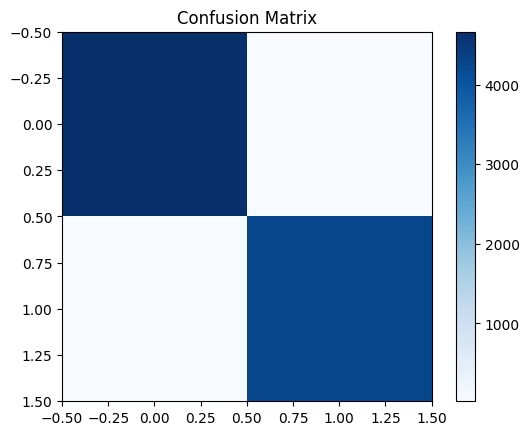

In [15]:
y_pred = svm.predict(X_test)
accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)b
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
print(classification_report(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
plt.show()

In [32]:
with open('word2vec_model.txt', 'r') as f:
    lines = f.readlines()
def predict_news(news_text):
    tokens = nltk.word_tokenize(news_text)
    vector = document_vector(tokens, word_vectors)
    prediction = svm.predict([vector])
    if prediction[0] == 0:
        return "Fake News"
    else:
        return "True News"
interface = gr.Interface(
    fn=predict_news,
    inputs="text",
    outputs="text",
    title="Fake News Detection",
    description="Enter a news article to classify it as Real or Fake.",
    examples = [" Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year.", "As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ..."]
)
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://363b8ddfda16ee8273.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
